In [1]:
import pandas as pd
import numpy as np
import datetime
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
import joblib
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn.utils import shuffle
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from scipy import stats

#### Processing functions

In [2]:
def create_df(income, balance, cashflow, ratios, prices):
    # Create df
    df = ratios[ratios.Date.ge('2019-06-01')]
    df = df.merge(income, how='left', on=['Date', 'Ticker'])
    df = df.merge(balance, how='left', on=['Date', 'Ticker'])
    df = df.merge(cashflow, how='left', on=['Date', 'Ticker'])
    df = df.sort_values(['Ticker', 'Date'], ascending=[True, False])

    # Feature engineering
    df.loc[df['EBITDA'].eq(0), 'EBITDA'] = np.nan
    df['EV / EBITDA'] = df['Enterprise Value'] / df['EBITDA']

    df['Book Val Change'] = df.groupby('Ticker')['Book Value Per Share'].shift(-1)
    df['Book Val Change'] = ((df['Book Value Per Share'] - df['Book Val Change']) / df['Book Value Per Share']).round(2)

    df['PE Ratio Change'] = df.groupby('Ticker')['PE Ratio'].shift(-1)
    df['PE Ratio Change'] = ((df['PE Ratio'] - df['PE Ratio Change']) / df['PE Ratio']).round(2)

    df['Gross Margin Change'] = df.groupby('Ticker')['Gross Margin %'].shift(-1)
    df['Gross Margin Change'] = ((df['Gross Margin %'] - df['Gross Margin Change']) / df['Gross Margin %']).round(2)

    df['Profit Margin Change'] = df.groupby('Ticker')['Profit Margin %'].shift(-1)
    df['Profit Margin Change'] = ((df['Profit Margin %'] - df['Profit Margin Change']) / df['Profit Margin %']).round(2)

    df['PS Ratio Change'] = df.groupby('Ticker')['PS Ratio'].shift(-1)
    df['PS Ratio Change'] = ((df['PS Ratio'] - df['PS Ratio Change']) / df['PS Ratio']).round(2)

    df['EV / EBITDA Change'] = df.groupby('Ticker')['EV / EBITDA'].shift(-1)
    df['EV / EBITDA Change'] = ((df['EV / EBITDA'] - df['EV / EBITDA Change']) / df['EV / EBITDA']).round(2)

    df['ROIC Change'] = df.groupby('Ticker')['Return on Capital (ROIC) %'].shift(-1)
    df['ROIC Change'] = ((df['Return on Capital (ROIC) %'] - df['ROIC Change']) / df['Return on Capital (ROIC) %']).round(2)

    df['Net Cash Change'] = df.groupby('Ticker')['Net Cash Per Share'].shift(-1)
    df['Net Cash Change'] = ((df['Net Cash Per Share'] - df['Net Cash Change']) / df['Net Cash Per Share']).round(2)

    df['Current Ratio Change'] = df.groupby('Ticker')['Current Ratio'].shift(-1)
    df['Current Ratio Change'] = ((df['Current Ratio'] - df['Current Ratio Change']) / df['Current Ratio']).round(2)

    # Drop missing Sector
    df = df[~df.Sector.eq('')]

    # Drop unused columns
    df = df.drop(['Enterprise Value', 'EBITDA'], axis=1)

    # Drop highly correlated features
    high_corr_cols = [
        'Quick Ratio', 'Total Shareholder Return %', 'Buyback Yield / Dilution %', 
        'Operating Margin %', 'Free Cash Flow Margin %', 'EBITDA Margin %', 'EBIT Margin %', 
        'Debt Growth %', 'Cash Growth %', 'Net Income Growth %', 'Free Cash Flow Growth %',
        ]
    df = df.drop(high_corr_cols, axis=1)

    # We change the report date with the next day after an offset of 40 days, because we need 
    # the prices after the report is public, so we must take into account the reports' deadline 
    df['Date'] = df['Date'] + pd.DateOffset(days=41)

    # We add an offset of 70 days to have the date before when we will take into account prices
    # fluctuations. Normally we have around 90 days between reports, but this changes between companies
    # so we leave a 20 days gap to avoid taking into account the prices after the next report appeared
    df['Max Date'] = df['Date'] + pd.DateOffset(days=70)

    # Because prices df has missing information for non-working dates, but our offset dates can be 
    # a non working date - we will fill this info with the prices from the next working day
    
    # Check the latest date in prices df
    price_info_max_date = prices.Date.max()

    # Take the dates before price_info_max_date and insert them to prices df to create dates
    # that are missing in prices df and that we will fill with the prices from the next working day
    df_date = df.loc[df['Date'].le(price_info_max_date), ['Date', 'Ticker']]
    prices = pd.merge(df_date, prices, on=['Date', 'Ticker'], how='outer')
    prices = prices.sort_values(['Ticker', 'Date'], ascending=[True, False])

    # The same we do for Max Date
    df_max_date = df[['Max Date', 'Ticker']].rename(columns={'Max Date': 'Date'})
    df_max_date = df_max_date.loc[df_max_date['Date'].le(price_info_max_date)]
    prices = pd.merge(df_max_date, prices, on=['Date', 'Ticker'], how='outer')
    prices = prices.sort_values(['Ticker', 'Date'], ascending=[True, False])
    
    # Fill missing prices so the prices df will cover now all the dates from the full df
    prices = prices.ffill()
    
    # Align prices to dates in the full df
    df = df.merge(prices, how='left', on=['Date', 'Ticker'])

    # Add Max Date as separate column to prices df
    max_prices = pd.merge(prices, df[['Date', 'Max Date', 'Ticker']], on=['Date', 'Ticker'], how='left')

    # Fill all the missing Max Date with the same value for each period Date - Max Date,
    # then we group by Max Date and Ticker to find the maximum price for each period and stock
    # this will be the price_target
    max_prices['Max Date'] = max_prices['Max Date'].bfill()
    max_prices = max_prices.groupby(['Ticker', 'Max Date'])['Price'].max().reset_index()
    max_prices = max_prices.rename(columns={'Price': 'price_target'})

    # Add the price_target to the full df
    df = df.merge(max_prices, how='left', on=['Max Date', 'Ticker'])

    # Calculate the price_change that will represent the ratio of maximum price growth 
    # this will be the prediction target of the model
    df['price_change'] = ((df['price_target'] - df['Price']) / df['Price']).round(2)

    # Delete the price_target and price_change values for the Max Date later than the last 
    # available report date because these prices we must predict. Max Date in this
    # cases is in the future and the price_target already filled here are the maximum prices just to the 
    # current day
    df.loc[df['Max Date'].gt(df['Date'].max()), ['price_target', 'price_change']] = np.nan
    
    # Drop outliers based on graphs analysis that follows in EDA
    df = df.loc[~df['Market Cap Growth %'].gt(400)]
    df = df.loc[~(df['PE Ratio'].lt(-50) | df['PE Ratio'].gt(200))]
    df = df[~(df['PS Ratio'].lt(0) | df['PS Ratio'].gt(30))]
    df = df[~(df['PB Ratio'].lt(-10) | df['PB Ratio'].gt(80))]
    df = df[~(df['P/FCF Ratio'].lt(-100) | df['P/FCF Ratio'].gt(500))]
    df = df[~(df['P/OCF Ratio'].lt(-100) | df['P/OCF Ratio'].gt(200))]
    df = df[~(df['Debt / Equity Ratio'].lt(-20) | df['Debt / Equity Ratio'].gt(40))]
    df = df[~df['Current Ratio'].gt(40)]
    df = df[~(df['Interest Coverage'].lt(-500) | df['Interest Coverage'].gt(1000))]
    df = df[~(df['Return on Capital (ROIC) %'].lt(-50) | df['Return on Capital (ROIC) %'].gt(100))]
    df = df[~df['Dividend Yield %'].gt(25)]
    df = df[~(df['Payout Ratio %'].lt(-500) | df['Payout Ratio %'].gt(1000))]
    df = df[~df['Revenue Growth (YoY) %'].gt(300)]
    df = df[~(df['Shares Change %'].lt(-30) | df['Shares Change %'].gt(100))]
    df = df[~(df['Free Cash Flow Per Share'].lt(-20) | df['Free Cash Flow Per Share'].gt(40))]
    df = df[~df['Dividend Growth %'].gt(500)]
    df = df[~df['EPS Growth %'].gt(5000)]
    df = df[~(df['Gross Margin %'].lt(-25) | df['Gross Margin %'].gt(110))]
    df = df[~(df['Profit Margin %'].lt(-100) | df['Profit Margin %'].gt(150))]
    df = df[~(df['Effective Tax Rate %'].lt(-200) | df['Effective Tax Rate %'].gt(200))]
    df = df[~df['Net Cash / Debt Growth %'].gt(1000)]
    df = df[~(df['Net Cash Per Share'].lt(-200) | df['Net Cash Per Share'].gt(200))]
    df = df[~(df['Book Value Per Share'].lt(-50) | df['Book Value Per Share'].gt(300))]
    df = df[~df['Operating Cash Flow Growth %'].gt(1000)]
    df = df[~(df['EV / EBITDA'].lt(-100) | df['EV / EBITDA'].gt(200))]
    df = df[~(df['Book Val Change'].lt(-1) | df['Book Val Change'].gt(0.75))]
    df = df[~(df['PE Ratio Change'].lt(-10) | df['PE Ratio Change'].gt(10))]
    df = df[~(df['Gross Margin Change'].lt(-3) | df['Gross Margin Change'].gt(3))]
    df = df[~(df['Profit Margin Change'].lt(-50) | df['Profit Margin Change'].gt(50))]
    df = df[~(df['PS Ratio Change'].lt(-2) | df['PS Ratio Change'].gt(0.8))]
    df = df[~(df['EV / EBITDA Change'].lt(-40) | df['EV / EBITDA Change'].gt(40))]
    df = df[~(df['ROIC Change'].lt(-10) | df['ROIC Change'].gt(10))]
    df = df[~(df['Net Cash Change'].lt(-10) | df['Net Cash Change'].gt(10))]
    df = df[~df['Current Ratio Change'].lt(-2)]
    df = df[~df['price_change'].gt(2)]

    # Convert dtypes
    num_cols = df.select_dtypes(np.number).columns
    df[num_cols] = df[num_cols].astype('float32')
    
    return df.reset_index(drop=True)

#### Plotting functions

In [3]:
def plot_corr_to_target(corr):
    '''
    Plot the correlation of all the features related to target
    '''
    corr_to_target = corr['price_change'].sort_values(ascending=False)
    corr_to_target[1:].plot(kind='barh', figsize=(10,7), title='Features correlation to price_change')
    plt.show()

def plot_feats_corr(corr):
    '''
    Plot the correlation between the features
    '''
    top_right_mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(18, 13))
    sns.heatmap(
        corr,
        # mask=(corr<0.9),
        mask=top_right_mask,
        linewidth=0.5,
        linecolor='white',
        annot=True,
        annot_kws={'size': 7},
        cmap='crest',
    )
    plt.title('Correlation between features')
    plt.show()

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df[column].lt(lower_bound) | df[column].gt(upper_bound)]

def scatterplot_all(df):
    '''
    Scatterplot all the features outliers
    '''
    features = df.select_dtypes(np.number).columns
    target = 'price_change'
    num_cols = 5
    num_rows = (len(features) + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 5, num_rows * 4)) 

    for i, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.scatterplot(data=df, x=feature, y=target, 
                        color='blue', label='Data', alpha=0.1)
        
        outliers = detect_outliers(df, feature)
        sns.scatterplot(data=outliers, x=feature, y=target, 
                        color='red', label='Outliers', alpha=0.1)
        
        plt.title(f'{feature} vs {target}')
        plt.xlabel(feature)
        plt.ylabel(target)

        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def boxplot_all(df):
    '''
    Boxplot all the features outliers
    '''
    features = df.select_dtypes(np.number).columns
    num_cols = 3
    num_rows = (len(features) + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 6, num_rows * 1))

    for i, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(data=df, x=feature, color='blue')
        plt.title(f'Box plot of {feature}')
        plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

def histplot_all(df):
    '''
    Plot all the values distribution
    '''
    features = df.select_dtypes(np.number).columns
    num_cols = 5
    num_rows = (len(features) + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 5, num_rows * 4))

    for i, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

#### Load data

In [4]:
start_path = '100m_quarter_'
mid_path = '_04_2019_to_'
end_path = '05_2024'

# Read files
income = pd.read_parquet(start_path + 'income' + mid_path + end_path + '.parquet')
balance = pd.read_parquet(start_path + 'balance' + mid_path + end_path + '.parquet')
cashflow = pd.read_parquet(start_path + 'cashflow' + mid_path + end_path + '.parquet')
ratios = pd.read_parquet(start_path + 'ratios' + mid_path + end_path + '.parquet')
prices = pd.read_parquet('prices_01_2018_to_' + end_path + '.parquet')
tickers_gt_100m = pd.read_parquet('tickers_gt_100m.parquet')

# Select features
income_cols = [
    'Date', 'Ticker', 'EBITDA',
    'Revenue Growth (YoY) %', 'Net Income Growth %', 'Shares Change %',
    'EPS Growth %', 'Free Cash Flow Per Share', 'Dividend Growth %',
    'Gross Margin %', 'Operating Margin %', 'Profit Margin %', 'Free Cash Flow Margin %',
    'Effective Tax Rate %', 'EBITDA Margin %', 'EBIT Margin %', 
    ]
balance_cols = [
    'Date', 'Ticker', 'Cash Growth %', 'Debt Growth %', 'Net Cash / Debt Growth %',
    'Net Cash Per Share', 'Book Value Per Share', 
    ]
cashflow_cols = [
    'Date', 'Ticker', 'Operating Cash Flow Growth %', 'Free Cash Flow Growth %',
    ]
ratios_cols = [
    'Date', 'Ticker', 'Sector', 
    'Market Cap Growth %', 'Enterprise Value', 'PE Ratio', 'PS Ratio',
    'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
    'Quick Ratio', 'Current Ratio', 'Interest Coverage',
    'Return on Capital (ROIC) %', 'Dividend Yield %', 'Payout Ratio %',
    'Buyback Yield / Dilution %', 'Total Shareholder Return %',
]
income = income[income_cols]
balance = balance[balance_cols]
cashflow = cashflow[cashflow_cols]
ratios = ratios[ratios_cols]

#### EDA

In [5]:
# Create df
df = create_df(income, balance, cashflow, ratios, prices)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40095 entries, 0 to 40094
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          40095 non-null  datetime64[ns]
 1   Ticker                        40095 non-null  object        
 2   Sector                        40095 non-null  object        
 3   Market Cap Growth %           37121 non-null  float32       
 4   PE Ratio                      37777 non-null  float32       
 5   PS Ratio                      37065 non-null  float32       
 6   PB Ratio                      37801 non-null  float32       
 7   P/FCF Ratio                   37236 non-null  float32       
 8   P/OCF Ratio                   37240 non-null  float32       
 9   Debt / Equity Ratio           37700 non-null  float32       
 10  Current Ratio                 28385 non-null  float32       
 11  Interest Coverage           

In [6]:
# # Plot data for analysis
# corr = df.corr(numeric_only=True)
# plot_corr_to_target(corr)
# plot_feats_corr(round(corr*100))
# scatterplot_all(df)
# boxplot_all(df)

#### Split data

Samples left: 30899


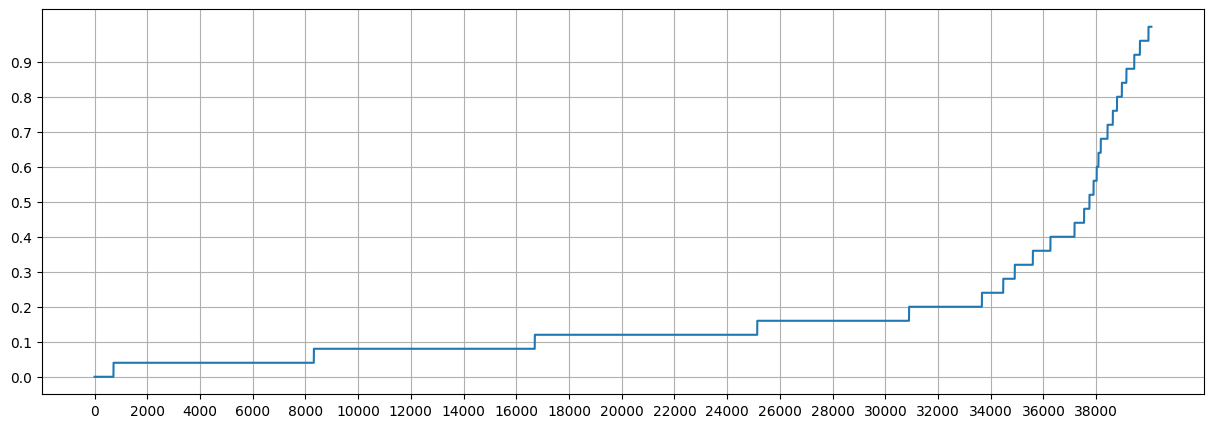

In [7]:
# Find a threshold from where missing important features ratio increase quicker
def plot_important_missing(missing):
    plt.figure(figsize=(15,5))
    sns.lineplot(missing.sort_values(ascending=True).reset_index(drop=True))
    x_step_size = 2000
    plt.xticks(np.arange(0, 40000, x_step_size))
    y_step_size = 0.1
    plt.yticks(np.arange(0, 1, y_step_size))
    plt.grid()
    plt.show()

# Most important features deducted from the model
important_cols = [
    'Payout Ratio %', 'PS Ratio Change', 'Market Cap Growth %',
    'PE Ratio',  'PS Ratio', 'Book Value Per Share',
    'Return on Capital (ROIC) %', 'P/FCF Ratio', 'P/OCF Ratio',
    'ROIC Change', 'Operating Cash Flow Growth %', 'Shares Change %',
    'Current Ratio', 'Revenue Growth (YoY) %', 'Return on Capital (ROIC) %',
    'PE Ratio Change', 'Net Cash Per Share', 'EV / EBITDA', 'Interest Coverage',
    'PB Ratio', 'Gross Margin Change', 'Dividend Yield %', 'Net Cash / Debt Growth %',
    'EPS Growth %', 'Profit Margin Change',
]
# Missing important features ratio by row
missing = df[important_cols].isna().mean(axis=1)
ids_to_keep = missing[missing.lt(0.2)]

print(f'Samples left: {len(ids_to_keep)}')
plot_important_missing(missing)

At around 20% of missing important features by row the increase begin to accelerate, we will use this threshold to filter the data

In [8]:
# Filter missing values by row
df_filtered = df.iloc[ids_to_keep.index]

# Prediction set split
df_pred = df_filtered[df_filtered['price_change'].isna()]

# Train set split
X = df_filtered[~df_filtered['price_change'].isna()]
y = X['price_change']

# Drop unuseful columns
cols_to_drop = ['Date', 'Max Date', 'Ticker', 'Price', 'price_target', 'price_change']
X = X.drop(cols_to_drop, axis=1)
X_pred = df_pred[X.columns]

# Shuffle data
X, y = shuffle(X, y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print(f'X shape: {X.shape}')
print(f'X_pred shape: {X_pred.shape}')

#### Process data

In [12]:
# Columns types
num_cols = X_train.select_dtypes(np.number).columns
cat_cols = X_train.select_dtypes(object).columns

# Pipeline to process numerical columns
num_pipeline = make_pipeline(
    PowerTransformer(copy=False),
    )
# Pipeline to process categorical columns
cat_pipeline = make_pipeline(
    OneHotEncoder(
        dtype=np.int8, drop='if_binary', sparse_output=False,
        min_frequency=0.02, handle_unknown='infrequent_if_exist'),
    )
# Define column transformer
processor = make_column_transformer(
    (num_pipeline, num_cols),
    (cat_pipeline, cat_cols),
    verbose=False,
    )

In [13]:
# Transform data
X_train = pd.DataFrame(
    processor.fit_transform(X_train, y_train), 
    columns=processor.get_feature_names_out(),
    index=X_train.index
    )
X_val = pd.DataFrame(
    processor.transform(X_val), 
    columns=processor.get_feature_names_out(),
    index=X_val.index
    )

In [11]:
# # Plot processed data distribution
# cols_to_histplot = ['pipeline-1__' + col for col in num_cols]
# histplot_all(X_train[cols_to_histplot])

#### Optuna tuning

In [12]:
def lgbm_objective(trial):
    """
    LGBMRegressor parameters search
    """
    params = {
        'n_estimators': 3000,
        'num_leaves': trial.suggest_int('num_leaves', 2, 250),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 1000),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        
        'metric': 'rmse',
        'verbosity': -1,
        'device': 'gpu',
        'n_jobs': -1,
    }
    model = lgbm.LGBMRegressor(**params)  
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[lgbm.log_evaluation(50), lgbm.early_stopping(50)],
              )
    y_pred = model.predict(X_val)
    
    return root_mean_squared_error(y_val, y_pred)

def xgb_objective(trial):
    """
    XGBRegressor parameters search
    """
    params = {
        'n_estimators': 3000,
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 1000),
        'max_delta_setp': trial.suggest_int('max_delta_setp', 0, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
        'alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10),
        
        'eval_metric': 'rmse',
        'verbosity': 0,
        'n_jobs': -1,
    }
    es = xgb.callback.EarlyStopping(rounds=50, maximize=False, save_best=True)
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[es],
             )
    y_pred = model.predict(X_val)
    
    return root_mean_squared_error(y_val, y_pred)

In [13]:
# %%time

# # Optuna study
# objective = lgbm_objective
# sampler = optuna.samplers.TPESampler(multivariate=True)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # Show best results
# trial = study.best_trial

# print('Number of finished trials: ', len(study.trials))
# print('Best trial:')
# print('Value:', trial.value)
# print('Params:')

# for key, value in trial.params.items():
#     print(f'{key}: {value}')

#### Test models

In [15]:
def train_model(model_type, params, X_train, X_val, y_train, y_val):
    """
    Train a specific model type with predefined parameters
    """    
    if model_type == 'lgbm':
        model = lgbm.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  callbacks=[lgbm.log_evaluation(50), lgbm.early_stopping(50)],
                 )
    elif model_type == 'xgb':
        es = xgb.callback.EarlyStopping(
            rounds=50, save_best=True,
            )
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  callbacks=[es],
                 )
    elif model_type == 'cb':
        train_data = cb.Pool(data=X_train, label=y_train)
        val_data = cb.Pool(data=X_val, label=y_val)
        model = cb.CatBoostRegressor(**params)  
        model.fit(train_data,
                  eval_set=val_data,
                  early_stopping_rounds=50,
                  )
    return model

def cross_val_predict_model(model_type, params, processor, X, y, cv=5):
    """
    Generate cross-validated estimates for each input data point
    """    
    if model_type == 'lgbm':
        model = lgbm.LGBMRegressor(**params)
    elif model_type == 'xgb':
        model = xgb.XGBRegressor(**params)
    elif model_type == 'cb':
        model = cb.CatBoostRegressor(**params)  

    val_pipeline = make_pipeline(processor, model)
    preds = cross_val_predict(val_pipeline, X, y, cv=cv, n_jobs=-1)
    
    return preds

In [16]:
# Best LGBM parameters
lgbm_params = {
    'n_estimators': 300,

    'num_leaves': 151, 
    'min_child_samples': 10, 
    'learning_rate': 0.02, 
    'reg_alpha': 1.7317627026508546, 
    'reg_lambda': 0.00453394148171287, 
    'colsample_bytree': 0.7606636429566893, 
    'subsample': 0.8509227243938231, 
    'subsample_freq': 9,

    'metric': 'rmse',
    'verbosity': -1,
    'device': 'gpu',
    'n_jobs': -1,
    'max_bin': 255,
    }
# Best XGB parameters
xgb_params = {
    'n_estimators': 400,

    'learning_rate': 0.02, 
    'max_depth': 10, 
    'min_child_weight': 74, 
    'max_delta_setp': 9, 
    'subsample': 0.8313560007100949, 
    'colsample_bytree': 0.7173850662466924, 
    'reg_lambda': 0.02513769112126553, 
    'reg_alpha': 0.009148985434231082, 
    'gamma': 1.9177328070816493e-06,

    'eval_metric': 'rmse',
    'verbosity': 0,
    'n_jobs': -1,
    }

In [17]:
# lgbm_model = train_model('lgbm', lgbm_params, X_train, X_val, y_train, y_val)

# # Plot LGBM model features importance
# lgbm.plot_importance(
#     lgbm_model, 
#     importance_type='gain', 
#     max_num_features=20, 
#     height=0.5,
#     grid=False,
#     precision=0,
#     title='LGBM feature importance',
#     )
# plt.show()

In [18]:
# # Train XGB model
# xgb_model = train_model('xgb', xgb_params, X_train, X_val, y_train, y_val)

# # Plot XGB model feature importance
# xgb.plot_importance(
#     xgb_model, 
#     max_num_features=20,
#     grid=False, 
#     importance_type='gain',
#     height=0.5,
#     title='XGB feature importance',
#     show_values=False,
#     )
# plt.show()

In [19]:
# Make cross validated predictions
y_pred = cross_val_predict_model('xgb', xgb_params, processor, X, y, cv=5)

In [36]:
def bad_preds_mae(y_true, y_pred):
    '''
    Custom metric to calculate MAE for predictions 
    that didn't hit the price_target
    '''
    differences = y_pred - y_true
    positive_differences = differences[differences > 0]
    
    return np.mean(np.abs(positive_differences))

metrics = {
    'RMSE for all predictions': root_mean_squared_error, 
    'MAE for all predictions': mean_absolute_error,
    "MAE for predictions that didn't hit the price target": bad_preds_mae,
}
for metric_name, metric in metrics.items():
    print(f'{round(metric(y, y_pred).astype(float), 2)} - {metric_name}')

0.15 - RMSE for all predictions
0.1 - MAE for all predictions
0.08 - MAE for predictions that didn't hit the price target


In [ ]:
# Calculate the margin of error and the confidence interval for average MAE
val_sample_size = 29110
mean_mae = 0.1
std = 0.146223
confidence_level = 0.95
z_value = 1.96

standard_error = std / np.sqrt(val_sample_size)
margin_of_error = round((standard_error * z_value), 3)
confidence_interval = stats.norm.interval(confidence=confidence_level, loc=mean_mae, scale=standard_error)
confidence_interval = (round(confidence_interval[0], 3), round(confidence_interval[1], 3))

print('Margin of error of MAE: ', margin_of_error)
print('Confidence interval for average MAE: ', confidence_interval)

Margin of error of MAE:  0.002
Confidence interval for average MAE:  (0.098, 0.102)


In [22]:
# Make a df with the differences from y_pred and y
preds_df = pd.DataFrame({'y': y, 'y_pred': y_pred})
preds_df['Diff'] = preds_df.y_pred - preds_df.y

# Separate predictions by threshold 
preds_1 = preds_df[preds_df.y_pred.ge(0.1)]
preds_2 = preds_df[preds_df.y_pred.ge(0.2)]
preds_3 = preds_df[preds_df.y_pred.ge(0.3)]
preds_4 = preds_df[preds_df.y_pred.ge(0.4)]

In [24]:
# Bad predictions details
preds_3.loc[preds_3['Diff'].gt(0), 'Diff'].describe()

count    680.000000
mean       0.198348
std        0.118376
min        0.000007
25%        0.100276
50%        0.195486
75%        0.285985
max        0.686477
Name: Diff, dtype: float64

In [52]:
# Bad predictions ratio
preds_3.y.lt(0.10).sum() / len(preds_3)

0.19429590017825313

#### Train final model

In [63]:
# Transform data for final training
X = pd.DataFrame(
    processor.fit_transform(X, y), 
    columns=processor.get_feature_names_out(),
    index=X.index
    )
X_pred = pd.DataFrame(
    processor.transform(X_pred), 
    columns=processor.get_feature_names_out(),
    index=X_pred.index
    )

In [64]:
train = False

if train:
    # Train and save final models
    lgbm_model = lgbm.LGBMRegressor(**lgbm_params)
    lgbm_model.fit(X, y)
    joblib.dump(lgbm_model, 'lgbm_model.pkl')

    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X, y)
    joblib.dump(xgb_model, 'xgb_model.pkl')

else:
    # Restore saved models
    lgbm_model = joblib.load('lgbm_model.pkl')
    xgb_model = joblib.load('xgb_model.pkl')

#### Predict

In [65]:
# Predict with each model
lgbm_preds = lgbm_model.predict(X_pred)
xgb_preds = xgb_model.predict(X_pred)

# The mean of each model's prediction
preds = np.vstack((lgbm_preds, xgb_preds)).mean(axis=0)

# Add predictions to dataframe
df_pred['price_change'] = preds
df_pred['price_target'] = df_pred['Price'] * (1 + df_pred['price_change'])

# Re-order columns
cols = df_pred.columns.tolist()
cols.insert(0, cols.pop(cols.index('price_change')))
cols.insert(0, cols.pop(cols.index('price_target')))
cols.insert(0, cols.pop(cols.index('Max Date')))
cols.insert(0, cols.pop(cols.index('Price')))
cols.insert(0, cols.pop(cols.index('Date')))
cols.insert(0, cols.pop(cols.index('Ticker')))
df_pred = df_pred[cols]

# Save predictions to xlsx
df_pred = df_pred.sort_values(['price_change', 'Max Date'], ascending=[False, False])
today = datetime.date.today().strftime('%Y_%m_%d')
df_pred.to_excel(f'Preds_{today}.xlsx', index=False)

In [71]:
# Predicted df
df_pred.sort_values(['Max Date', 'price_change'], ascending=[True, False]).head()

,Ticker,Date,Price,Max Date,price_target,price_change,Sector,Market Cap Growth %,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt / Equity Ratio,Current Ratio,Interest Coverage,Return on Capital (ROIC) %,Dividend Yield %,Payout Ratio %,Revenue Growth (YoY) %,Shares Change %,EPS Growth %,Free Cash Flow Per Share,Dividend Growth %,Gross Margin %,Profit Margin %,Effective Tax Rate %,Net Cash / Debt Growth %,Net Cash Per Share,Book Value Per Share,Operating Cash Flow Growth %,EV / EBITDA,Book Val Change,PE Ratio Change,Gross Margin Change,Profit Margin Change,PS Ratio Change,EV / EBITDA Change,ROIC Change,Net Cash Change,Current Ratio Change
6226,CALM,2024-04-10,61.509998,2024-06-19,71.832150,0.167813,Consumer Defensive,-4.330000,9.920000,1.15,1.59,11.000000,6.940000,NaN,5.65,NaN,25.600000,5.5,3.9,-29.520000,0.090000,-54.680000,2.75,-91.410004,31.090000,20.870001,20.910000,7.720000,14.210000,35.380001,-54.669998,10.308026,0.06,0.46,0.44,0.84,0.22,-4.02,-0.46,0.18,-0.22
8293,CNXC,2024-04-10,59.419998,2024-06-19,68.856080,0.158803,Technology,-32.549999,17.280001,0.61,1.17,14.550000,9.110000,1.23,1.56,1.880000,5.690000,1.2,0.0,46.830002,27.809999,-54.759998,-1.57,NaN,35.650002,2.170000,28.450001,NaN,-72.989998,62.459999,NaN,28.315454,-0.07,-0.15,-0.03,-0.43,-0.44,-0.27,-0.20,-0.03,0.12
20051,KARO,2024-04-10,26.850000,2024-06-19,30.947557,0.152609,Technology,-2.280000,20.059999,3.52,5.00,14.840000,14.840000,0.09,1.49,47.209999,26.540001,3.4,0.0,18.770000,NaN,44.889999,-2.86,NaN,65.830002,19.360001,28.940001,-75.430000,NaN,95.680000,NaN,1.610641,0.08,-0.07,0.03,0.06,-0.02,NaN,-0.00,NaN,0.07
30120,RELL,2024-04-10,9.350000,2024-06-19,10.757745,0.150561,Technology,-58.810001,29.059999,0.60,0.79,-42.169998,50.009998,0.02,5.06,NaN,5.520000,2.7,120.0,-25.570000,-1.500000,-88.639999,-0.20,NaN,29.469999,1.430000,23.389999,-29.219999,1.090000,11.110000,NaN,52.403847,0.00,0.33,0.04,3.85,-0.42,3.78,-0.84,-0.32,0.08
388,ACI,2024-04-10,20.860001,2024-06-19,23.933332,0.147331,Consumer Defensive,12.240000,9.530000,0.16,4.50,14.600000,4.640000,5.18,0.84,3.890000,10.040000,1.7,0.0,0.410000,6.640000,-21.820000,0.78,NaN,28.049999,1.370000,20.430000,NaN,-24.100000,4.770000,18.770000,26.469820,0.08,0.02,0.00,-0.42,0.00,0.10,-0.02,-0.04,-0.01
